<a href="https://colab.research.google.com/github/mohammadRahimi1993/BigData/blob/main/KnowldgeGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
!pip install textacy
!pip install spacytextblob
!python -m textblob.download_corpora
!python -m spacy download en_core_web_sm

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.
     |████████████████████████████████| 13.9 MB 19.7 MB/s 
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 2.2.5
    Uninstalling en-core-web-sm-2.2.5:
      Successfully uninstalled en-core-web-sm-2.2.5
✔ Download and installation successful
Y

# **1. Knowledge Graphs - Data Preprocessing**
# **1.1. Load Data**

In [24]:
import pandas as pd
movie_plots_data = pd.read_csv('/content/gdrive/MyDrive/wiki_movie_plots_deduped.csv')
print(movie_plots_data.shape)

(34886, 8)


# **1.2. Select Subset**

In [25]:
#Data Selection
movie_plots_data_selection = movie_plots_data[movie_plots_data['Release Year'] >= 2005]
plots = movie_plots_data_selection.Plot
plots


14591    Andy Stitzer is a 40-year-old virgin who lives...
14592    51 Birch Street is the first-person account of...
14593    Max is a lonely child in the suburbs of Austin...
14594    In 2011, a deadly pathogenic virus has killed ...
14595    In 1974, Ronald DeFeo Jr. murdered his family ...
                               ...                        
34881    The film begins in 1919, just after World War ...
34882    Two musicians, Salih and Gürkan, described the...
34883    Zafer, a sailor living with his mother Döndü i...
34884    The film centres around a young woman named Am...
34885    The writer Orhan Şahin returns to İstanbul aft...
Name: Plot, Length: 10052, dtype: object

In [26]:
phrases = []
for plot in plots.head(3000):
    phrases_all = plot.split('.')
    phrases_filtered = [p.strip() for p in phrases_all if p.strip() and len(p.strip()) > 3]
    phrases += phrases_filtered

# 1.3. Split Movie Plots Into Sentences

In [27]:
from textacy.extract import subject_verb_object_triples
import spacy
nlp = spacy.load('en_core_web_sm')
doc = nlp('They are watching a movie')
iterator = subject_verb_object_triples(doc)
for it in iterator:
    print(it)

SVOTriple(subject=[They], verb=[are, watching], object=[movie])


# **1.4. Extract SVO Triples**

In [32]:
# 1.4. Extract triples: subject-verb-object (SVO)
from tqdm import tqdm
triples_raw = []

for i in tqdm(phrases[0:1000]):  # TODO: remove limited no. phrases
    iterator = subject_verb_object_triples(nlp(i))
    phrase_triples = []
    for svo in iterator:
        phrase_triples.append(svo)   
    triples_raw.append(phrase_triples)

100%|██████████| 1000/1000 [00:10<00:00, 91.03it/s]


# 1.5. Lematize + Stem Triples

In [33]:
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus.reader.wordnet import VERB
lemmatizer = WordNetLemmatizer()

In [34]:
lemmatized_triples = []
lemmatized_stemmed_triples = []
stemmer = SnowballStemmer('english')

In [35]:
from nltk.stem import SnowballStemmer
def lemmatize_stemming(text):
    # lemmatize + stem a text
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

In [36]:
phrase_counter = 0
detected_counter = 0

for (phrase, phrase_triples) in zip(phrases, triples_raw):
    print('phrase triples:', phrase_triples)
    phrase_counter += 1
    if phrase_triples:
        detected_counter += 1
        for triple in phrase_triples:
            print('raw:', triple)
            # lemmatize 
            s = lemmatizer.lemmatize(str(triple[0]))
            o = lemmatizer.lemmatize(str(triple[2]))
            v = lemmatizer.lemmatize(str(triple[1][-1]), VERB)  # take last token in verb expression
            
            # lemmatize + stem
            lss = lemmatize_stemming(str(triple[0]))
            lso = lemmatize_stemming(str(triple[2]))
            lsv = lemmatize_stemming(str(triple[1][-1]))
            
            print('lemmatized: s:', s, ', o:', o, ', v:', v)
            print('lemmatized+stemmed: s:', lss, ', o:', lso, ', v:', lsv)
            
            lemmatized_triples.append([s.lower(), v.lower(), o.lower()])
            lemmatized_stemmed_triples.append([lss.lower(), lsv.lower(), lso.lower()])
    else:
        print('Could not detect triples in phrase:', phrase)
        lemmatized_triples.append([])
        lemmatized_stemmed_triples.append([])

Streaming output truncated to the last 5000 lines.
Could not detect triples in phrase: 51 Birch Street is the first-person account of a family's life-changing events
phrase triples: [SVOTriple(subject=[father], verb=[calls], object=[him])]
raw: SVOTriple(subject=[father], verb=[calls], object=[him])
lemmatized: s: [father] , o: [him] , v: call
lemmatized+stemmed: s: [father] , o: [him] , v: call
phrase triples: []
Could not detect triples in phrase: Always close to his mother and equally distant from his father, Doug and his two older sisters were shocked and suspicious
phrase triples: [SVOTriple(subject=[Mike, Kitty], verb=[marry], object=[family, home]), SVOTriple(subject=[Mike, Kitty], verb=[sell], object=[family, home])]
raw: SVOTriple(subject=[Mike, Kitty], verb=[marry], object=[family, home])
lemmatized: s: [Mike, Kitty] , o: [family, home] , v: marry
lemmatized+stemmed: s: [mike, kitty] , o: [family, home] , v: marri
raw: SVOTriple(subject=[Mike, Kitty], verb=[sell], object=[fam

In [37]:
print('Detection rate: ', (detected_counter / phrase_counter) * 100, '%')

Detection rate:  76.5 %


# **2. Create Graph**
# **2.1. Create SOV Pandas DataFrame**

In [40]:
# use only sentences with non-empty SOV triples
sources = []
relations = []
targets = []
for ep_item in lemmatized_stemmed_triples:
    # check found items are not empty
    if ep_item:
        print(ep_item)
        # append source/relation/target
        sources.append(ep_item[0])
        relations.append(ep_item[1])
        targets.append(ep_item[2])
# create DataFrame
kg_df = pd.DataFrame({'source': sources, 'target': targets, 'edge': relations})
kg_df.tail()

['[him]', 'lose', '[virginity]']
['[men]', 'give', '[andy, advice]']
['[cal]', 'advis', '[andy]']
['[he]', 'practic', '[which]']
['[who]', 'intrigu', '[him]']
['[david]', 'give', '[porn, collection]']
['[mooj]', 'stress', '[importance]']
['[andy]', 'begin', '[to, socialize, and, form, friendships, with, his, co, -]']
['[david]', 'have', '[breakdown]']
['[manager, paula]', 'promot', '[andy]']
['[jay]', 'attempt', '[to, quicken, the, process, by, tricking, andy, into, meeting, a, prostitute]']
['[andy]', 'discov', '[hooker]']
['[friends]', 'stop', '[trying, to, help, him]']
['[andy]', 'land', '[date]']
['[they]', 'interrupt', '[daughter]']
['[they]', 'postpon', '[having, sex, ,, to, which, andy, enthusiastically, agrees]']
['[friends]', 'begin', '[to, encounter, the, consequences, of, their, lifestyles]']
['[david]', 'take', '[vow]']
['[sex]', 'ruin', '[relationship]']
['[trish]', 'encourag', '[dream]']
['[they]', 'fund', '[it]']
['[andy]', 'take', '[marla]']
['[she]', 'know', '[to, let,

,source,target,edge
1311,"[luc, lola]",[church],leav
1312,[they],[ritual],consumm
1313,[others],[jimmy],free
1314,[who],[them],tell
1315,[harold],"[crow, dance]",perform


# **2.2. Top Subjects (Sources)**

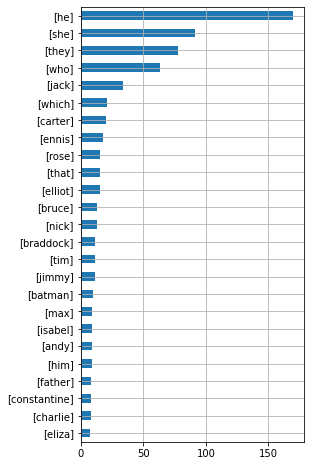

In [41]:
kg_df.source.value_counts()[:25].sort_values().plot.barh(figsize=(4,8), grid=True)

# **2.3. Top Objects (Targets)**

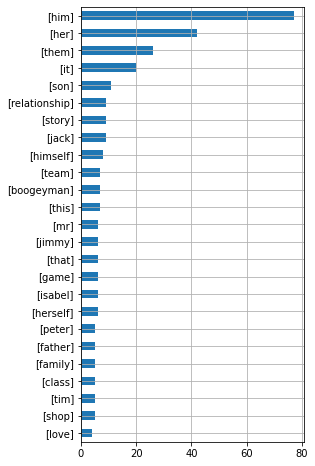

In [42]:
kg_df.target.value_counts()[:25].sort_values().plot.barh(figsize=(4,8), grid=True)

# **2.4. Top verbs (Edge/Relations)**

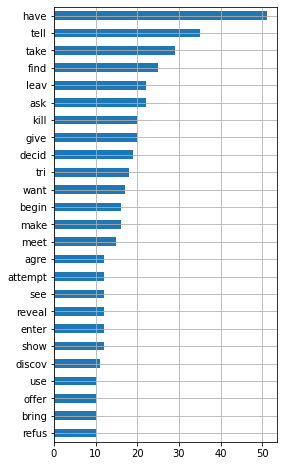

In [43]:
kg_df.edge.value_counts()[:25].sort_values().plot.barh(figsize=(4,8), grid=True)

In [66]:
import networkx as nx
# create a directed graph from a Pandas dataframe
G = nx.from_pandas_edgelist(kg_df, "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())

# **2.6. Find Links**

In [86]:

edge_attrs = [v['edge'] for k, v in G.get_edge_data('[he]', '[her]').items()]
print(set(edge_attrs))
d = {x:edge_attrs.count(x) for x in set(edge_attrs)}
print(sorted(d.items(), key=lambda item: item[1], reverse=True))

{'bring', 'ask', 'buri'}
[('ask', 2), ('bring', 1), ('buri', 1)]


# **2.7. Depth First Search via NetworkX**

In [82]:
selected_nodes = [n for (n, v, e) in G.edges(data=True) if (e['edge'] in ['tell', 'ask'])]
SG = G.subgraph(selected_nodes)
nx_SG = nx.dfs_tree(SG, source='[she]', depth_limit=1)
print(len(list(nx_SG.edges())))

6


# **2.8. Visualization**

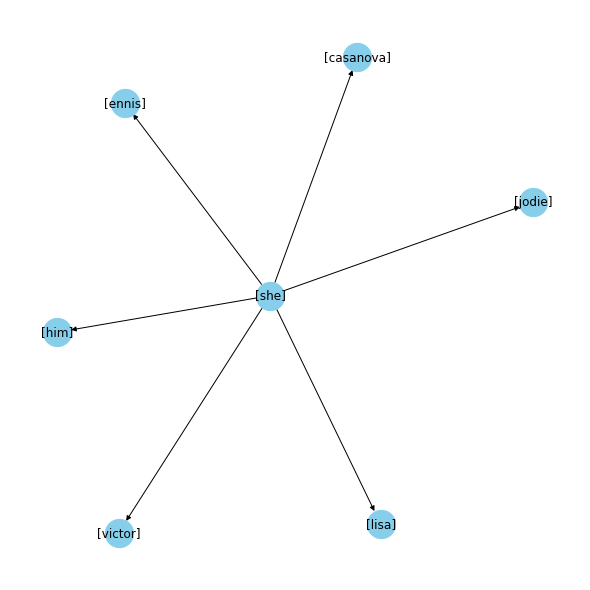

In [87]:
from matplotlib import pylab as plt
plt.figure(figsize=(8,8))
pos = nx.spring_layout(nx_SG, k=0.5)  # k regulates the distance between nodes
nx.draw(nx_SG, with_labels=True, node_color='skyblue', node_size=800, edge_cmap=plt.cm.Blues, pos=pos)
plt.show()

In [89]:
nx_SG = nx.dfs_tree(SG, source='[she]', depth_limit=2)
print(len(list(nx_SG.edges())))
plt.figure(figsize=(8,8))
pos = nx.spring_layout(nx_SG, k=0.5)  

8


<Figure size 576x576 with 0 Axes>